In [5]:
import sys, os
import xarray as xr
import tensorflow as tf
import numpy as np

# 如果在 Colab 上工作，先挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 手动指定 src 目录的绝对路径，假设您的项目位于 Google Drive 中
module_path = '/content/drive/MyDrive/weather_forecast_project/src'
if module_path not in sys.path:
    sys.path.append(module_path)

print("模块搜索路径已添加：", module_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
模块搜索路径已添加： /content/drive/MyDrive/weather_forecast_project/src


In [6]:
from tensorflow.keras.models import load_model

# 加载已保存的模型
model = load_model('/content/drive/MyDrive/weather_forecast_project/my_model.keras')
print("模型已加载。")


模型已加载。


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
from data_preprocessor import DataProcessor

# 初始化数据预处理器
data_processor = DataProcessor(lead_time=28)

# 指定原始数据文件路径
file_path = r"/content/drive/MyDrive/complete_era5_data.nc"

# 加载和预处理数据集
ds = data_processor.load_dataset(file_path)
ds = data_processor.load_and_check(ds)
print("数据集加载并预处理完成。")


加载数据集: /content/drive/MyDrive/complete_era5_data.nc
所有必要的基本变量均存在。
处理缺失值...
变量 't2m' 存在 5742296 个缺失值，已用均值填充。
变量 'msl' 存在 5742296 个缺失值，已用均值填充。
变量 'u10' 存在 5742296 个缺失值，已用均值填充。
变量 'v10' 存在 5742296 个缺失值，已用均值填充。
变量 'tcwv' 存在 5742296 个缺失值，已用均值填充。
变量 'blh' 存在 5742296 个缺失值，已用均值填充。
变量 'sp' 存在 5742296 个缺失值，已用均值填充。
变量 'tp' 存在 5702280 个缺失值，已用均值填充。
数据集加载并预处理完成。


In [8]:
# 假设我们使用2015年之后的数据作为测试集
split_time = '2015-01-01'
test_ds = ds.sel(valid_time=slice(split_time, None))
print(f"测试集数据从 {split_time} 开始，共有 {test_ds.sizes['valid_time']} 个时间点。")


测试集数据从 2015-01-01 开始，共有 8400 个时间点。


In [9]:
# 基于测试集创建特征和目标
features_test_ds = data_processor.create_features(test_ds)
targets_test_da = data_processor.create_targets(test_ds)
print("测试集特征和目标创建完成。")


创建基础特征...
计算衍生特征: wind_speed
添加时间特征...
创建2米温度距平作为预测目标...
测试集特征和目标创建完成。


In [10]:
# 将测试集特征沿 'channel' 维度合并，并调整维度顺序
features_test_combined = xr.concat(
    [features_test_ds[var] for var in features_test_ds.data_vars],
    dim='channel'
).transpose('valid_time', 'latitude', 'longitude', 'channel')

def data_generator(features_ds, sequence_length):
    import numpy as np
    total_steps = features_ds.sizes['valid_time']
    num_samples = total_steps - sequence_length
    for i in range(num_samples):
        X = features_ds.isel(valid_time=slice(i, i+sequence_length)).values.astype(np.float32)
        yield X

sequence_length = 30
batch_size = 16

channels = features_test_combined.sizes['channel']
height = features_test_combined.sizes['latitude']
width = features_test_combined.sizes['longitude']

output_shapes = (sequence_length, height, width, channels)
output_types = tf.float32

predict_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(features_test_combined, sequence_length),
    output_types=output_types,
    output_shapes=output_shapes
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("预测数据集已创建。")


预测数据集已创建。


In [11]:
# 使用加载的模型对测试数据进行预测
predictions = model.predict(predict_dataset)
print("预测完成。")
print("预测结果的形状：", predictions.shape)


524/524 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


预测完成。
预测结果的形状： (8370, 1)


In [12]:
# 提取真实目标值用于比较
def extract_true_targets(target_da, sequence_length):
    # 计算目标时间点的空间平均值
    true_values = []
    total_steps = target_da.sizes['valid_time']
    num_samples = total_steps - sequence_length
    for i in range(num_samples):
        # 对应每个预测，取第 i+sequence_length 时刻的空间平均目标
        val = target_da.isel(valid_time=i+sequence_length).mean(dim=['latitude', 'longitude']).item()
        true_values.append(val)
    return np.array(true_values).reshape(-1, 1)

true_targets = extract_true_targets(targets_test_da, sequence_length)
print("真实目标形状：", true_targets.shape)


真实目标形状： (8370, 1)


In [13]:
from sklearn.metrics import mean_squared_error

# 确保 predictions 与 true_targets 大小一致
min_samples = min(len(predictions), len(true_targets))
mse = mean_squared_error(true_targets[:min_samples], predictions[:min_samples])
print(f"均方误差 (MSE): {mse}")


均方误差 (MSE): 14.49690584972065


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

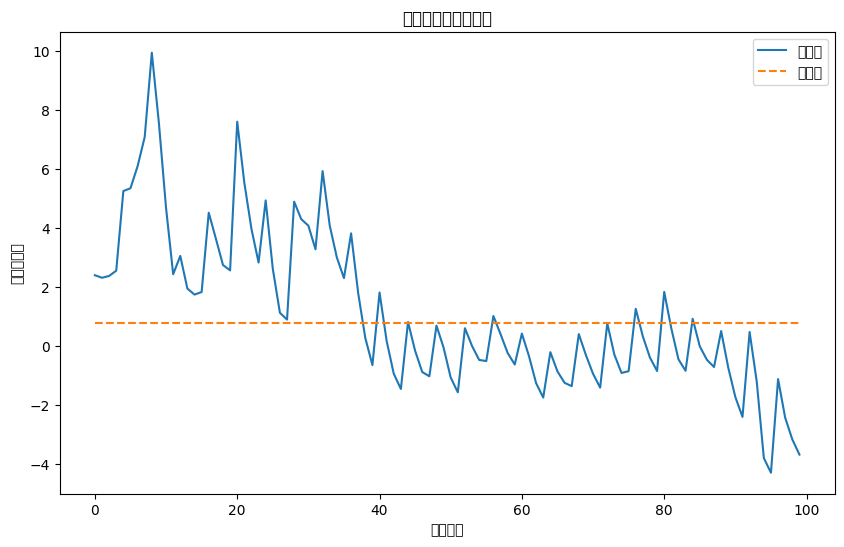

In [14]:
import matplotlib.pyplot as plt

# 假设true_targets和predictions已定义且对齐
plt.figure(figsize=(10, 6))
plt.plot(true_targets[:100], label='真实值')
plt.plot(predictions[:100], label='预测值', linestyle='--')
plt.title('预测值与真实值对比')
plt.xlabel('样本索引')
plt.ylabel('目标变量值')
plt.legend()
plt.show()


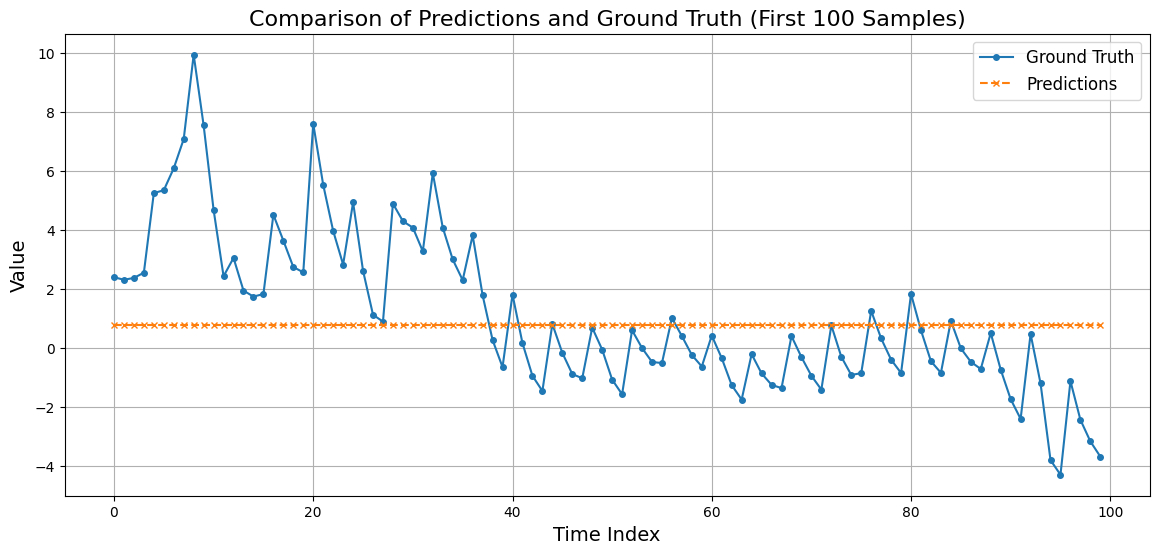

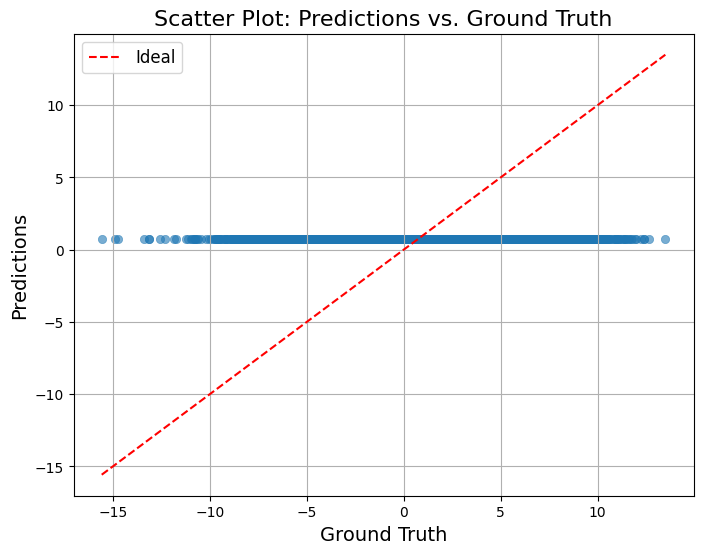

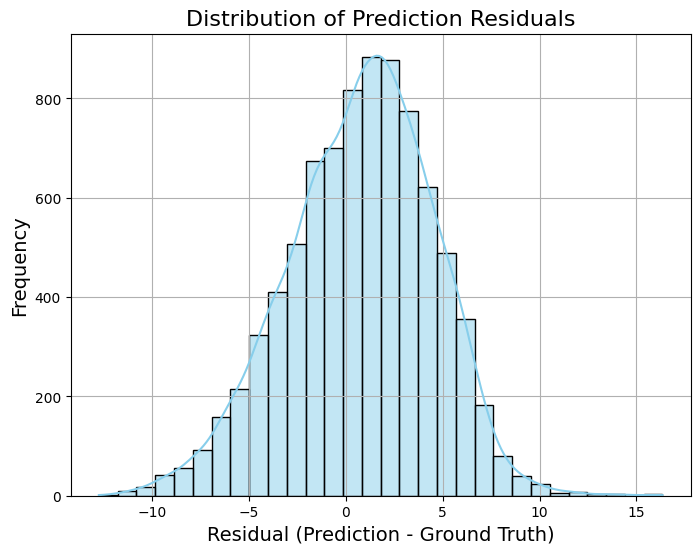

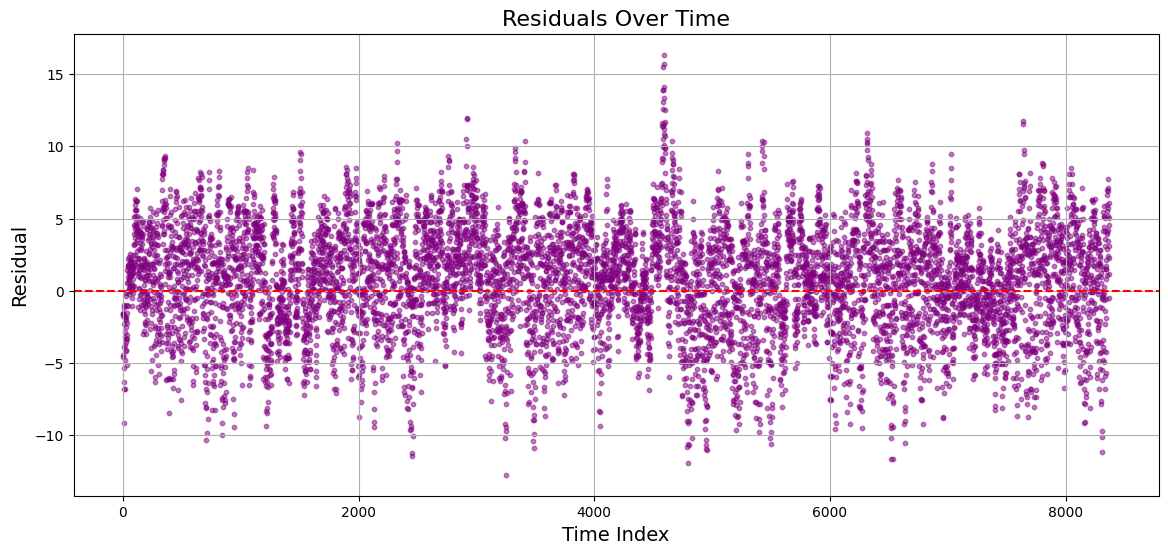

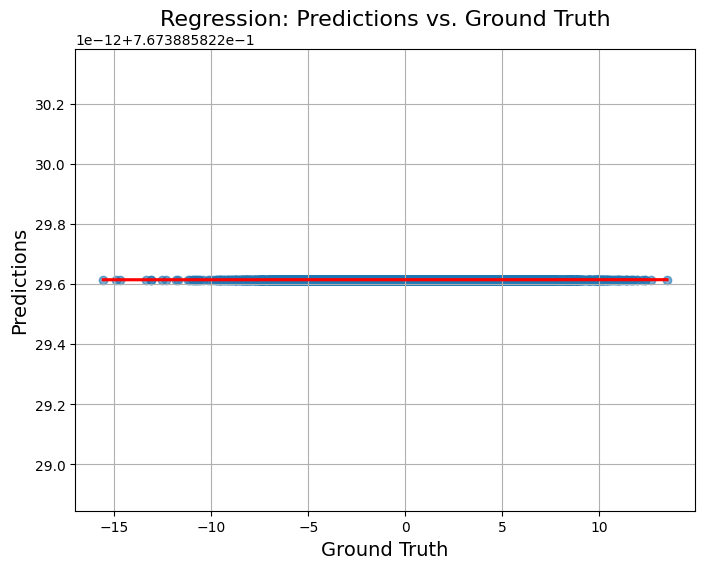

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming predictions and true_targets are numpy arrays of shape (N, 1)
# Flatten them to 1D arrays for easier handling
preds = predictions.flatten()
truths = true_targets.flatten()
residuals = preds - truths

# 1. Time Series Comparison for the First 100 Samples
plt.figure(figsize=(14, 6))
plt.plot(truths[:100], label='Ground Truth', marker='o', markersize=4)
plt.plot(preds[:100], label='Predictions', marker='x', markersize=4, linestyle='--')
plt.title('Comparison of Predictions and Ground Truth (First 100 Samples)', fontsize=16)
plt.xlabel('Time Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 2. Scatter Plot of Predictions vs. Ground Truth
plt.figure(figsize=(8, 6))
sns.scatterplot(x=truths, y=preds, alpha=0.6, edgecolor=None)
# Plotting a y=x reference line for ideal prediction
min_val = min(truths.min(), preds.min())
max_val = max(truths.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal')
plt.title('Scatter Plot: Predictions vs. Ground Truth', fontsize=16)
plt.xlabel('Ground Truth', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 3. Histogram of Residuals with KDE
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Prediction Residuals', fontsize=16)
plt.xlabel('Residual (Prediction - Ground Truth)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# 4. Residuals Over Time
plt.figure(figsize=(14, 6))
plt.scatter(np.arange(len(residuals)), residuals, alpha=0.5, s=10, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Over Time', fontsize=16)
plt.xlabel('Time Index', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.grid(True)
plt.show()

# 5. Scatter Plot with Regression Line (Optional)
plt.figure(figsize=(8, 6))
sns.regplot(x=truths, y=preds, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Regression: Predictions vs. Ground Truth', fontsize=16)
plt.xlabel('Ground Truth', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.grid(True)
plt.show()


In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def generate_model_performance_report(true_values, predictions):
    """
    Generate and print a comprehensive performance report for regression models.

    Args:
        true_values (array-like): Ground truth target values.
        predictions (array-like): Model predictions.

    Returns:
        dict: A dictionary containing computed performance metrics.
    """
    # Flatten arrays to 1D
    y_true = np.array(true_values).flatten()
    y_pred = np.array(predictions).flatten()

    # Compute performance metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Create a formatted report string
    report = f"""
    Model Performance Report:
    -------------------------
    Mean Squared Error (MSE): {mse:.4f}
    Root Mean Squared Error (RMSE): {rmse:.4f}
    Mean Absolute Error (MAE): {mae:.4f}
    R^2 Score: {r2:.4f}
    """
    print(report)

    # Return metrics dictionary for further use if needed
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# 示例调用：
# 假设 true_targets 和 predictions 已经定义并且对齐
# 将前 min_samples 个样本用于计算指标（确保长度匹配）
min_samples = min(len(true_targets), len(predictions))
report_metrics = generate_model_performance_report(true_targets[:min_samples], predictions[:min_samples])



    Model Performance Report:
    -------------------------
    Mean Squared Error (MSE): 14.4969
    Root Mean Squared Error (RMSE): 3.8075
    Mean Absolute Error (MAE): 3.0845
    R^2 Score: -0.0424
    
